2026-01-16 09:09:52.589522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768554593.006640      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768554593.138637      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768554594.196721      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768554594.196765      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768554594.196768      55 computation_placer.cc:177] computation placer alr

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Experiment: T1_Sigmoid...


I0000 00:00:1768554613.319314      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768554613.323174      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1768554617.079918     124 service.cc:152] XLA service 0x7eee8400a210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768554617.079952     124 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768554617.079958     124 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768554617.498247     124 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768554621.439200     124 device_compiler.h:188] Compiled clust

Done. Test Acc: 0.0980

Running Experiment: T1_Tanh...
Done. Test Acc: 0.9836

Running Experiment: T1_ReLU...
Done. Test Acc: 0.9910

Running Experiment: T2_SGD...
Done. Test Acc: 0.9695

Running Experiment: T2_SGD_Momentum...
Done. Test Acc: 0.9885

Running Experiment: T3_NoBN_NoDrop...
Done. Test Acc: 0.9864

Running Experiment: T3_NoBN_Drop0.1...
Done. Test Acc: 0.9889

Running Experiment: T3_WithBN_Drop0.25...
Done. Test Acc: 0.9870

Running Experiment: CNN-1...
Done. Test Acc: 0.9897

Running Experiment: MLP-1...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Done. Test Acc: 0.9782

Running Experiment: MLP-2...
Done. Test Acc: 0.9790


=== Final Results Table ===
            Experiment Model Activation     Optimizer  Test Accuracy
0           T1_Sigmoid   CNN    sigmoid          Adam         0.0980
1              T1_Tanh   CNN       tanh          Adam         0.9836
2              T1_ReLU   CNN       relu          Adam         0.9910
3               T2_SGD   CNN       relu           SGD         0.9695
4      T2_SGD_Momentum   CNN       relu  SGD_Momentum         0.9885
5       T3_NoBN_NoDrop   CNN       relu          Adam         0.9864
6      T3_NoBN_Drop0.1   CNN       relu          Adam         0.9889
7   T3_WithBN_Drop0.25   CNN       relu          Adam         0.9870
8                CNN-1   CNN       relu          Adam         0.9897
9                MLP-1   MLP       relu           SGD         0.9782
10               MLP-2   MLP       relu          Adam         0.9790


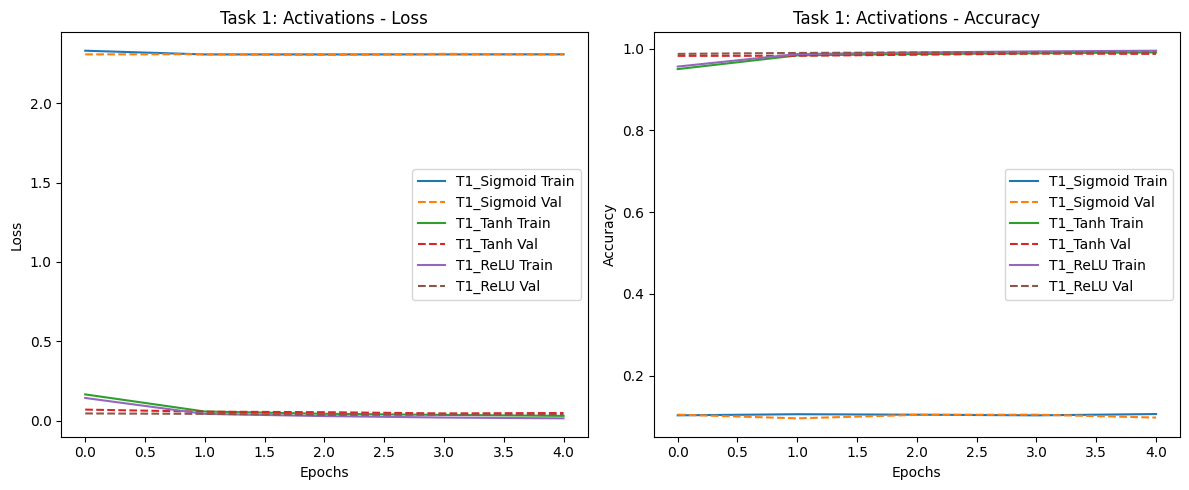

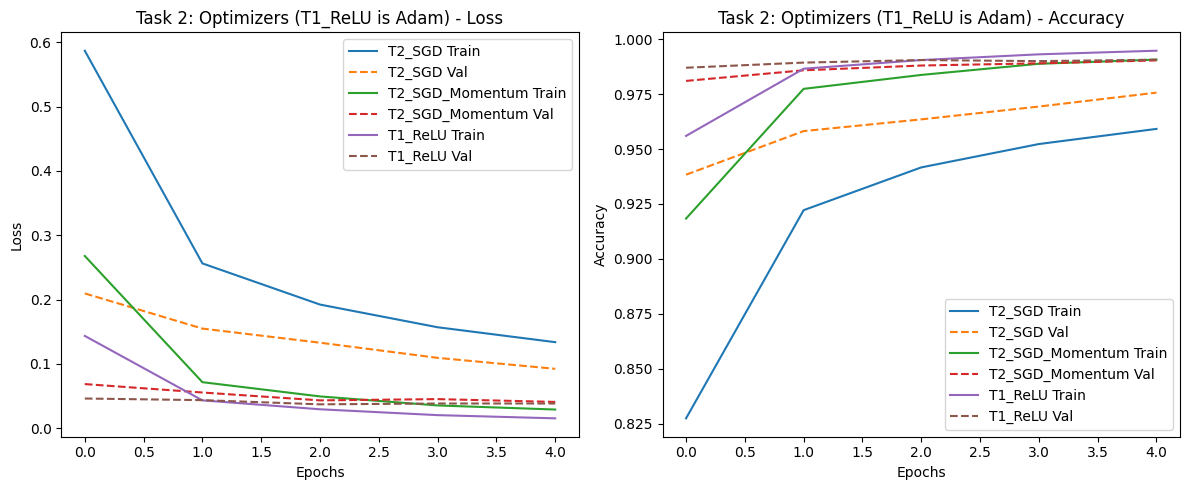

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

#standardization- mean 0 variance 1
#normalization- all values- scale to 0-1
#dropout- randomly turn off neurons during training to prevent overfitting
# 1. Data Loading & Preprocessing
def load_data():
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize pixel values to be between 0 and 1 (normalization)
    x_train = x_train.astype('float32') / 255.0 #Pixel values are originally 0–255. Dividing by 255 scales them to 0.0–1.0.
    x_test = x_test.astype('float32') / 255.0

    # Reshape for CNN (28, 28, 1) -> adding channel dimension (1 as grayscale)
    x_train_cnn = np.expand_dims(x_train, -1)
    x_test_cnn = np.expand_dims(x_test, -1)

    # Flatten for MLP (784) - technically Keras flatten layer handles this, 
    # but we keep raw shape for input layer definition.

    # One-hot encode targets
    #One-Hot Encoding: to_categorical converts a label like 5 into a vector: [0,0,0,0,0,1,0,0,0,0].
    #This is necessary for the Softmax output layer to calculate "probability" for each of the 10 digits.
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return (x_train_cnn, y_train), (x_test_cnn, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

# 2. Model Builders
def build_cnn(activation='relu', dropout_rate=0.25, use_bn=False):
    """
    Builds the CNN.
    """
    model = models.Sequential()
    
    # Input Layer & Conv2D Layer 1
    #Conv2D: Applies filters to the image to extract features.
    #BatchNormalization (BN): Standardizes the inputs to each layer, making training much more stable.
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation=activation)) #32 filters of size 3x3
    if use_bn: model.add(layers.BatchNormalization())

    # Conv2D Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation=activation)) #64 filters of size 3x3
    if use_bn: model.add(layers.BatchNormalization())
    
    # Max Pooling
    #MaxPooling2D: Shrinks the image size, keeping only the most important information.
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Dropout (Variable rate based on Task 3)
    #Dropout: Randomly shuts off neurons during training to prevent Overfitting (making the model too reliant on specific pixels).
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    
    # Flatten & Dense
    model.add(layers.Flatten()) #to convert multi-dimensional data into a 1D vector.
    model.add(layers.Dense(128, activation=activation)) #Fully connected layer with 128 neurons
    if use_bn: model.add(layers.BatchNormalization()) #BatchNormalization scales the data -> mean of 0 and variance of 1.
    
    # Output Layer
    model.add(layers.Dense(10, activation='softmax')) #10 classes for digits 0-9 with Softmax activation for probability distribution.
    #softmax activation ensures the outputs sum to 1, making them interpretable as probabilities.
    #softmax= exp(xi)/sum(exp(xj)) for all j, where xi is the input to the neuron for class i.
    
    return model

def build_mlp(hidden_layers=[256, 128], activation='relu'): #256->1st and 128->2nd neurons in hidden layers
    """
    Builds the MLP.
    """
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1))) #Flatten input for MLP, grayscale image input.
    
    for units in hidden_layers:
        model.add(layers.Dense(units))
        model.add(layers.BatchNormalization()) #mean 0, variance 1
        model.add(layers.Activation(activation))
       
    model.add(layers.Dense(10, activation='softmax')) #Output layer for 10 classes with Softmax activation.
    return model

# 3. Experiment Runner
results = []
history_dict = {}

def run_experiment(name, model_type, optimizer_name, activation, epochs, dropout=0.25, use_bn=False, hidden_layers=None):
    print(f"Running Experiment: {name}...")
    
    # Select Model Architecture
    if model_type == 'CNN':
        model = build_cnn(activation=activation, dropout_rate=dropout, use_bn=use_bn)
    elif model_type == 'MLP':
        model = build_mlp(hidden_layers=hidden_layers, activation=activation)
    
    # Configure Optimizer
    if optimizer_name == 'Adam': # speed fast, stability good, learning rate adaptive
        opt = optimizers.Adam()
    elif optimizer_name == 'SGD': # speed slow, stabitity high, learning rate
        opt = optimizers.SGD(learning_rate=0.01)
    elif optimizer_name == 'SGD_Momentum': # speed moderate, stability high, learning rate with momentum
        opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train
    hist = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_split=0.1, verbose=0)
    
    # Evaluate
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    
    # Log Results
    results.append({
        'Experiment': name,
        'Model': model_type,
        'Activation': activation,
        'Optimizer': optimizer_name,
        'Epochs': epochs,
        'Dropout': dropout,
        'Batch Norm': use_bn,
        'Test Accuracy': round(test_acc, 4)
    })
    
    history_dict[name] = hist.history
    print(f"Done. Test Acc: {test_acc:.4f}\n")

# 4. Running Tasks

# --- Task 1: Activation Function Challenge ---
# Comparing Sigmoid, Tanh, ReLU on Base CNN
run_experiment("T1_Sigmoid", "CNN", "Adam", "sigmoid", 5)
run_experiment("T1_Tanh", "CNN", "Adam", "tanh", 5)
run_experiment("T1_ReLU", "CNN", "Adam", "relu", 5)

# --- Task 2: Optimizer Showdown ---
# Using best activation (ReLU)
run_experiment("T2_SGD", "CNN", "SGD", "relu", 5)
run_experiment("T2_SGD_Momentum", "CNN", "SGD_Momentum", "relu", 5)
# (Adam was run in T1_ReLU)

# --- Task 3: Regularization Scenarios  ---
# 1. Without BN, Drop out = 0 (No dropout)
run_experiment("T3_NoBN_NoDrop", "CNN", "Adam", "relu", 5, dropout=0.0, use_bn=False)
# 2. Without BN, Drop out = 0.1
run_experiment("T3_NoBN_Drop0.1", "CNN", "Adam", "relu", 5, dropout=0.1, use_bn=False)
# 3. With BN, Drop out = 0.25
run_experiment("T3_WithBN_Drop0.25", "CNN", "Adam", "relu", 5, dropout=0.25, use_bn=True)

# --- Page 1 Specific Models Table ---
# CNN-1: 128 FC, Adam, 10 epochs (Standard Base CNN)
run_experiment("CNN-1", "CNN", "Adam", "relu", 10, dropout=0.25)

# MLP-1: 512-256-128, SGD, 20 epochs
run_experiment("MLP-1", "MLP", "SGD", "relu", 20, hidden_layers=[512, 256, 128])

# MLP-2: 256, Adam, 15 epochs
# Note: Source 26 says "256", implying one hidden layer or 256-128 based on context. 
# We will assume [256] as per table entry "256".
run_experiment("MLP-2", "MLP", "Adam", "relu", 15, hidden_layers=[256])

# 5. Visualization & Reporting

# Create DataFrame
df_results = pd.DataFrame(results)
print("\n=== Final Results Table ===")
print(df_results[['Experiment', 'Model', 'Activation', 'Optimizer', 'Test Accuracy']])

# Plotting Helper
def plot_experiments(experiment_names, title):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    for name in experiment_names:
        plt.plot(history_dict[name]['loss'], label=f'{name} Train')
        plt.plot(history_dict[name]['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for name in experiment_names:
        plt.plot(history_dict[name]['accuracy'], label=f'{name} Train')
        plt.plot(history_dict[name]['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Visualize Task 1 (Activations) 
plot_experiments(["T1_Sigmoid", "T1_Tanh", "T1_ReLU"], "Task 1: Activations")
#vanishing gradient problem- sigmoid and tanh saturate at extreme values, causing gradients to become very small.
#ReLU does not saturate for positive values, allowing gradients to remain significant and enabling deeper networks to learn effectively.

# Visualize Task 2 (Optimizers) 
plot_experiments(["T2_SGD", "T2_SGD_Momentum", "T1_ReLU"], "Task 2: Optimizers (T1_ReLU is Adam)")
#SGD with momentum helps accelerate gradients vectors in the right directions, leading to faster converging.
#Adam combines the advantages of two other extensions of stochastic gradient descent, namely Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).
#It computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.